# Mike's playground

In [1]:
from importlib import reload
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

import utils
import data
reload(utils);
reload(data);

2022-10-25 06:14:45.079061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
utils.select_subset_for_playground(1000)  # choose different numbers for different env

In [4]:
dataset_to_work_with="playground"
train_ds = utils.load_tf_dataset(dataset=dataset_to_work_with)
validation_ds = utils.load_tf_dataset(dataset=dataset_to_work_with, subset="validation")
train_ds.class_names

Found 1000 files belonging to 8 classes.
Using 800 files for training.


2022-10-25 06:16:25.058566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1000 files belonging to 8 classes.
Using 200 files for validation.


['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

In [5]:
# Weights for each class
reload(utils)
y_data = utils.subdir_dict.get(dataset_to_work_with).get("y")
skin_class_proportions = 1 / y_data.drop(columns=["image", "UNK"]).sum() * (y_data.shape[0] / 2)

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# Formula and idea from tf site: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

class_weight = {i: skin_class_proportions[name] for i, name in enumerate(train_ds.class_names)}
class_weight

{0: 2.1929824561403506,
 1: 2.0408163265306123,
 2: 2.304147465437788,
 3: 7.142857142857142,
 4: 2.976190476190476,
 5: 26.31578947368421,
 6: 50.0,
 7: 11.627906976744185}

In [6]:
model = utils.build_model(
    [
        *utils.preprocess_layers(),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=8,
            activation='softmax',
            use_bias=True,
            # kernel_initializer=tf.zeros_initializer,
        ),
    ],
    metrics=[
        tf.keras.metrics.Accuracy(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
    ],
    loss="categorical_crossentropy",
)

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

history = model.fit(
    train_ds,
    epochs=30,
    batch_size=30,
    verbose=1,
    validation_data=validation_ds,
    class_weight=class_weight,
    # callbacks=[callback],
)

Epoch 1/30
800/800 [==============================] - 98s 122ms/step - loss: 11800.7510 - accuracy: 0.7873 - recall: 0.1875 - precision: 0.1875 - val_loss: 3278.1721 - val_accuracy: 0.7519 - val_recall: 0.0800 - val_precision: 0.0800
Epoch 2/30
800/800 [==============================] - 98s 122ms/step - loss: 10618.0537 - accuracy: 0.7903 - recall: 0.2025 - precision: 0.2025 - val_loss: 4148.4941 - val_accuracy: 0.7887 - val_recall: 0.1700 - val_precision: 0.1700
Epoch 3/30
800/800 [==============================] - 96s 120ms/step - loss: 11656.7910 - accuracy: 0.7917 - recall: 0.2062 - precision: 0.2062 - val_loss: 2906.7065 - val_accuracy: 0.7775 - val_recall: 0.1350 - val_precision: 0.1350
Epoch 4/30
800/800 [==============================] - 96s 120ms/step - loss: 11571.8574 - accuracy: 0.7869 - recall: 0.1912 - precision: 0.1912 - val_loss: 5624.7944 - val_accuracy: 0.7569 - val_recall: 0.0450 - val_precision: 0.0450
Epoch 5/30
800/800 [==============================] - 96s 120ms/

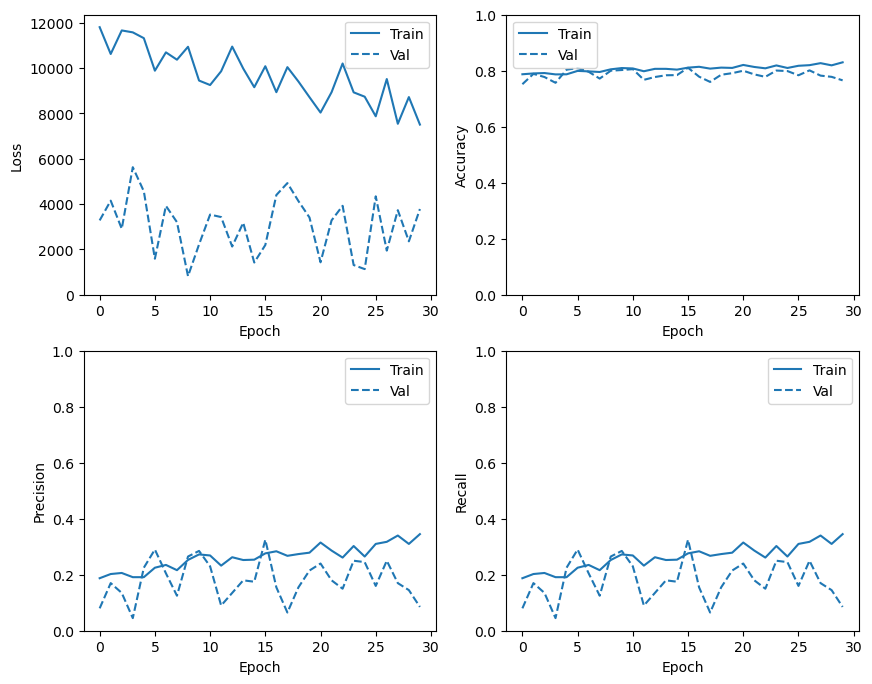

In [10]:
utils.plot_metrics(history)

2022-10-26 05:22:22.198774: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


Image ID: ISIC_0070973
Actual label:    [1. 0. 0. 0. 0. 0. 0. 0.]
Predicted label: [1. 0. 0. 0. 0. 0. 0. 0.]


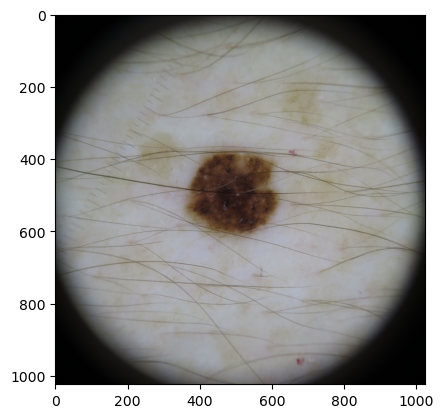

In [15]:
for i, (img, label_one_hot) in validation_ds.enumerate(start=6):
    
    img_id = validation_ds.file_paths[i].split("/")[-1].replace(".jpg", "")
    print(f"Image ID: {img_id}")
    print(f"Actual label:    {label_one_hot[0]}")
    
    # Make prediction
    pred_label = model.predict([img], verbose=0)
    print(f"Predicted label: {pred_label[0]}")
    
    # plot image for reference
    utils.plot_image_by_id(img_id)
    
    break  # Optionally break at different point for multiple images